After submitting admissions the students were awarded with some amount of money, depending on the `Univeraity Rating` and `Chance of Admit`.

$$ \textrm{Award} = \textrm{Chance of Admit} * \textrm{multiplier}_{\textrm{University Rating}}$$

However some information has been lost:
- `Chance of Admit` for each student
- Multipliers

Fortunatelly we have information about the award amounts (`Award`) and students data (`GRE Score`, `TOEFL Score`, `University Rating`, `SOP`, `LOR`, `CGPA`, `Research`, `Chance of Admit`) from admissions.

Build a Bayesian model (possibly linear) for predicting `Chance of Admit` and use in a model that predicts `Award` and train them simultanously using `x_train` and `y_train_award`.

Evaluate the obtained models on:
- `x_test` and `y_test_award` with the stacked model
- `x_test` and `y_test_chance` with the "internal" model

In [3]:
%load_ext autoreload
%autoreload 2

import pickle
import pyro
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
import pyro.distributions as dist
from torch import nn
import torch
from torch.distributions import constraints
from pyro.optim import SGD, Adam
from matplotlib import pyplot as plt

In [4]:
import sys
sys.path.append('./')

In [5]:
from src.utils import run_svi, SviPredictive, summary
from src.visualization import plot_predictions

In [6]:
with open('./data/stacked-regression.pkl', 'rb') as f:
    data = pickle.load(f)
x_train = data['x_train']
y_train_award = data['y_train_award']
y_train_chance = data['y_train_chance']
x_test = data['x_test']
y_test_award = data['y_test_award']
y_test_chance = data['y_test_chance']

In [56]:
class BayesianLinearRegression(PyroModule):
    def __init__(self, n_input):
        super().__init__()
        self.n_input = n_input
        
    def model(self, x, y=None):
        intercept = pyro.sample(
                        'internal-intercept',
                        dist.Normal(0., 1.).expand([1]).to_event(1)
                    )
        
        coefficients = pyro.sample(
            'internal-coefficients',
            dist.Normal(0., 1.).expand([1, self.n_input]).to_event(2)
        )
        
        sigma = pyro.sample("internal-sigma", dist.Uniform(0., 2.))
        
        mean = coefficients @ x.t() + intercept
        
        with pyro.plate("internal-data", x.shape[0]):
            obs = pyro.sample('internal-obs', dist.Normal(mean, sigma), obs=y)
        return obs
    

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)
    
    def guide(self, x, y=None):
        loc = pyro.param(
            'internal-loc',
            torch.ones([1, self.n_input])
        )
        scale = pyro.param(
            'internal-scale',
            torch.ones([1, self.n_input])*0.1,
            constraint=constraints.positive
        )
        coefficients = pyro.sample('internal-coefficients', dist.Normal(loc, scale).to_event(2))
        
        
        intercept_loc = pyro.param(
            'internal-intercept_loc',
            torch.ones(1))
        intercept_scale = pyro.param(
            'internal-intercept_scale',
            torch.ones(1)*0.1,
            constraint=constraints.positive
        )
        intercept = pyro.sample(
            'internal-intercept',
            dist.Normal(intercept_loc, intercept_scale).to_event(1)
        )
        
        mean = coefficients @ x.t() + intercept
    
        sigma_loc = pyro.param(
            'internal-sigma_loc',
            torch.rand(1),
            constraint=constraints.positive
        )
        sigma = pyro.sample('internal-sigma', dist.Normal(sigma_loc, torch.Tensor([0.05])))
        with pyro.plate("internal-data", x.shape[0]):
            guide_obs = pyro.sample('internal-obs', dist.Normal(mean, sigma), obs=y)
        return guide_obs
        
    
class StackedModel(nn.Module):
    
    def __init__(self, n_input, initial_multipliers, university_rating_column, university_ratings):
        super().__init__()
        self.logit = nn.Sigmoid()
        self.linear_regression = BayesianLinearRegression(n_input)
        
        self.initial_multipliers = initial_multipliers
        self.university_rating_column = university_rating_column
        self.university_ratings = university_ratings
        
        
    def one_hot(self,unis,preds):
        matrix = torch.zeros(preds.shape[1], len(self.university_ratings))
        for i,pred in enumerate(preds[0,:]):
            pred = pred.item()
            uni = int(unis[i].item())
            matrix[i,uni-1] = pred
        return matrix
        
        
    def model(self, x, y=None):
        preds = self.linear_regression.model(x)
        preds = self.logit(preds)
        
        n_multipliers = len(self.university_ratings)

        multipliers = {
            k: pyro.param(f'multiplier_{k}', torch.Tensor([v]))
            for k, v in self.initial_multipliers.items()
        }
        
        ratings = x[:,self.university_rating_column]
        multipliers_tensor = torch.cat([ multipliers[int(i.item())] for i in ratings ])
    
        mean = multipliers_tensor * preds
        
        sigma = pyro.sample("stacked-sigma", dist.Uniform(0., 10.))
        with pyro.plate("stacked-data", x.shape[0]):
            obs = pyro.sample('stacked-obs', dist.Normal(mean, sigma), obs=y)
        return mean
    
    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)
    
    def guide(self, x, y=None):  
        multipiers = torch.Tensor(list(self.initial_multipliers.values()))
    
        preds = self.linear_regression.guide(x)
#         preds = self.logit(preds)
#         preds = self.one_hot(x[:,self.university_rating_column],preds)
#         mean = multipiers @ preds.t()
       
        sigma_loc = pyro.param(
            'stacked-sigma_loc',
            torch.rand(1),
            constraint=constraints.positive
        )
        sigma = pyro.sample('stacked-sigma', dist.Delta(sigma_loc))

{'internal-loc': tensor([[ 0.2996,  0.3119,  1.1679,  0.4361,  0.2830,  0.6057, -0.1601]],
       requires_grad=True), 'internal-scale': tensor([[0.0786, 0.0787, 0.0865, 0.0734, 0.0753, 0.0759, 0.0890]],
       grad_fn=<AddBackward0>), 'internal-intercept_loc': tensor([1.1884], requires_grad=True), 'internal-intercept_scale': tensor([0.0841], grad_fn=<AddBackward0>), 'internal-sigma_loc': tensor([0.2537], grad_fn=<AddBackward0>), 'stacked-sigma_loc': tensor([5.1688], grad_fn=<AddBackward0>), 'multiplier_1': tensor([87.5212], requires_grad=True), 'multiplier_2': tensor([53.0399], requires_grad=True), 'multiplier_3': tensor([34.1510], requires_grad=True), 'multiplier_4': tensor([98.7673], requires_grad=True), 'multiplier_5': tensor([58.1574], requires_grad=True)}


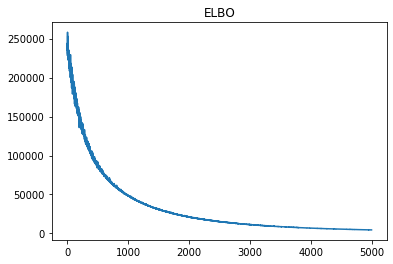

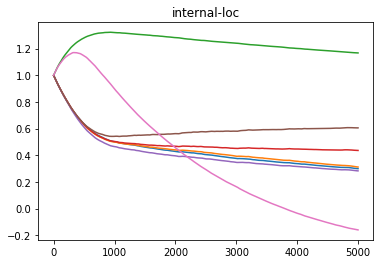

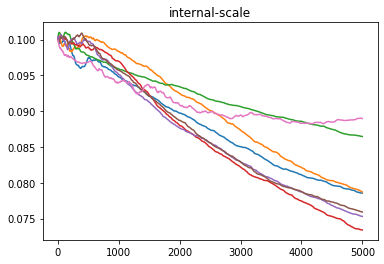

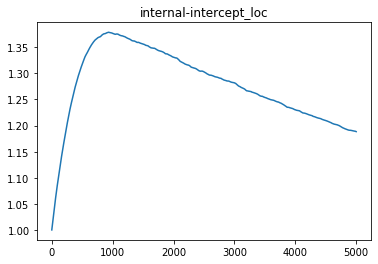

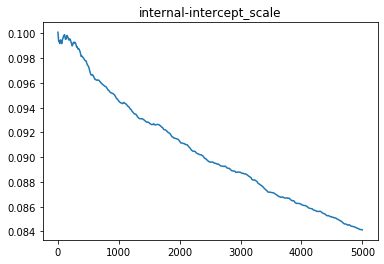

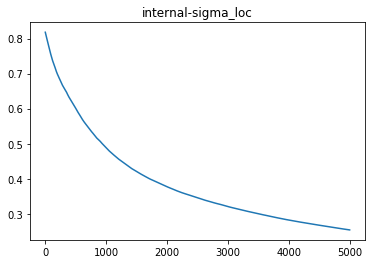

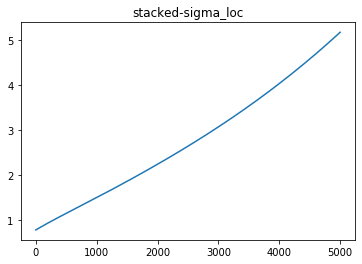

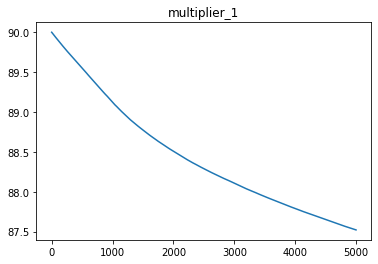

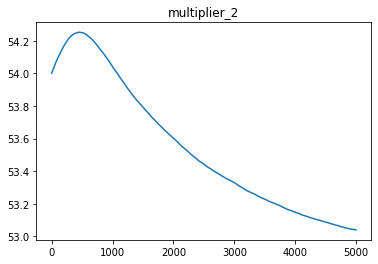

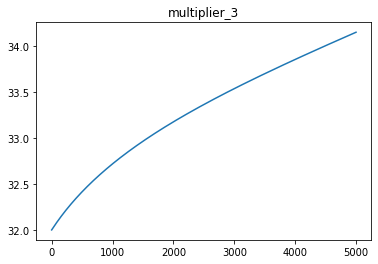

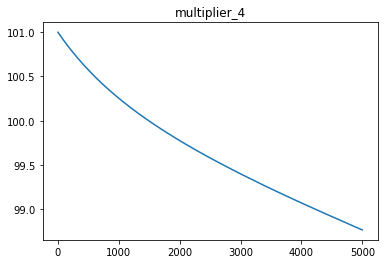

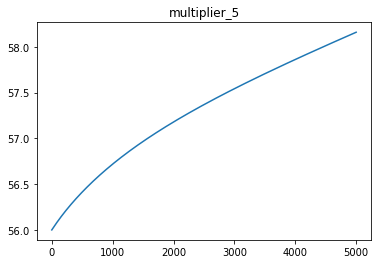

In [69]:
m = StackedModel(
    n_input=7,
    initial_multipliers={
        1: 90,
        2: 54,
        3: 32,
        4: 101,
        5: 56,
    },
    university_rating_column=2,
    university_ratings=range(1,6),
)

elbos, params = run_svi(
    m,
    m.guide,
    x_train,
    y_train_award,
    verbose=True,
    optimizer=Adam({"lr": 0.001}),
    num_iters=5_000,
    loss=TraceGraph_ELBO()
)
print(dict(pyro.get_param_store()))
plt.plot(elbos)
plt.title('ELBO')
plt.show()

for param in params[0].keys():
    y = [d[param].detach().reshape(-1).numpy() for d in params]
    plt.plot(y)
    plt.title(param)
    plt.show()

# Model evaluation

In [70]:
num_samples = 1_000

## Chance of Admit Model Evaluation

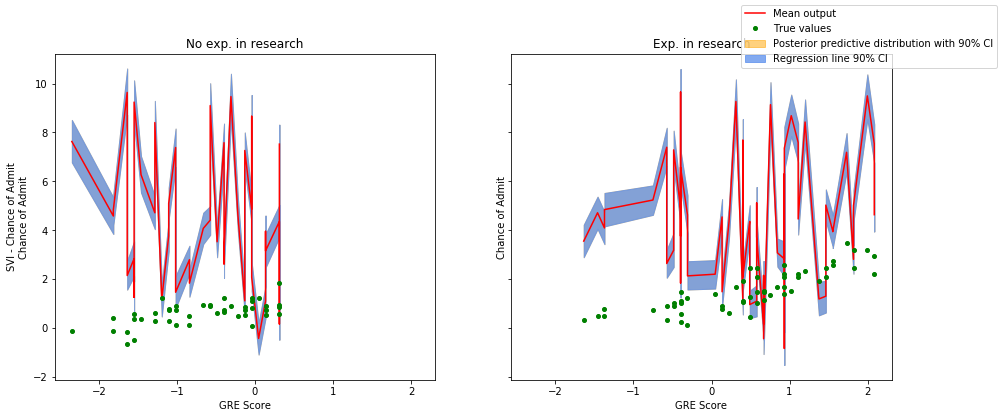

In [71]:
chance_predictive = SviPredictive(
    m.linear_regression.model,
    guide=m.linear_regression.guide,
    num_samples=num_samples,
    return_sites=('internal-obs','_RETURN')
)
properties = {
    'x': 0,
    'x_label': "GRE Score",
    'y_label': "Chance of Admit",
    'category': 6,
    'category_labels': {
        0: "No exp. in research",
        1: "Exp. in research",
    }
}
predictors = {
    'SVI - Chance of Admit': chance_predictive
}
data = {
    'x': x_test,
    'y': torch.log(y_test_chance / (1 - y_test_chance)) # inverse of nn.Sigmoid()
}
plot_predictions(data, predictors, properties, obs_site_name='internal-obs')

## Award Model Evaluation

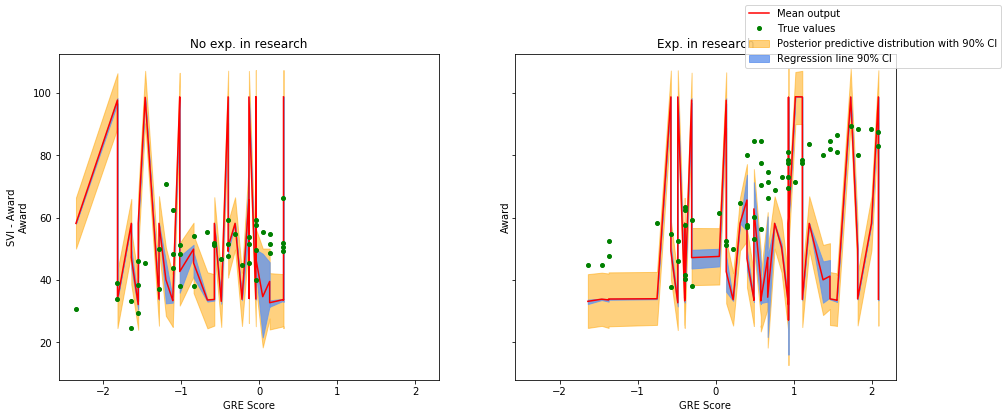

In [72]:
award_predictive = SviPredictive(
    m.model,
    guide=m.guide,
    num_samples=num_samples,
    return_sites=('stacked-obs','_RETURN')
)
properties = {
    'x': 0,
    'x_label': "GRE Score",
    'y_label': "Award",
    'category': 6,
    'category_labels': {
        0: "No exp. in research",
        1: "Exp. in research",
    }
}
predictors = {
    'SVI - Award': award_predictive
}
data = {
    'x': x_test,
    'y': y_test_award
}
plot_predictions(data, predictors, properties, obs_site_name='stacked-obs')